[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/visualize_conv_filters.ipynb)

When you haven't yet installed `tf-keras-vis` in your environment, please run the cell below.

In [ ]:
!pip install --upgrade pip
!pip install --upgrade tf-keras-vis tensorflow matplotlib

# Visualizing Conv filters using ActivationMaximization

### Load libraries

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

1 GPUs


### Load tf.keras.Model

This tutorial use VGG16 model in tf.keras but if you want to use other tf.keras.Models, you can do so by modifing section below.

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Visualizing a Conv filter

### Define a function to modify the model

First, you MUST define a modifier to replace the model output to target layer's output that has filters you want to visualize.

In [3]:
layer_name = 'block5_conv3' # The target layer that is the last layer of VGG16.

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    target_layer.activation = tf.keras.activations.linear
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    return new_model

### Create ActivationMaximization Instnace

When `clone` argument is True(default), the `model` will be cloned, so the `model` instance will be NOT modified, but it may take a while.
Here, because it does NOT need to do so, setting `False`.

In [4]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

### Define Score function

You MUST define `score` function that return arbitrary filter values. Here, it returns the value corresponding 63th filter of `block5_conv3` layer. ActivationMaximization will maximize the filter value.

In [5]:
from tf_keras_vis.utils.scores import CategoricalScore

filter_number = 63
score = CategoricalScore(filter_number)

# Instead of CategoricalScore function object, you can define the scratch function such as below:
def score_function(output):
    return output[..., filter_number]

### Visualize

ActivationMaximization will maximize the model output value that is computed by the score function. Here, we try to visualize a convolutional filter.

Steps: 100	Losses: [[468.4657897949219]],	Regularizations: [('TotalVariation2D', [115.48915100097656]), ('Norm', [3.359558582305908])]
Steps: 200	Losses: [[548.6751098632812]],	Regularizations: [('TotalVariation2D', [128.87451171875]), ('Norm', [3.430950880050659])]


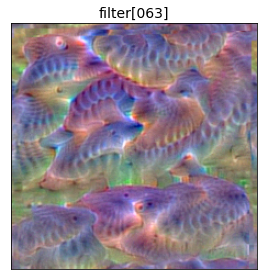

CPU times: user 9.22 s, sys: 1.15 s, total: 10.4 s
Wall time: 9.62 s


In [6]:
%%time
from tf_keras_vis.activation_maximization.callbacks import PrintLogger as Logger
from tf_keras_vis.activation_maximization.callbacks import GifGenerator2D

# Generate max activation
activations = activation_maximization(score,
                                      callbacks=[Logger(interval=100)])

# Render
subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (4, 4),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
ax.imshow(activations[0])
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
plt.tight_layout()
plt.show()

## Visualizing Conv filters

Then, let's visualize multiple convolutional filters!

### Define Score function

When visualizing multiple convolutional filters, you MUST define Score function that return arbitrary filter values for each layer.

In [7]:
from tf_keras_vis.utils.scores import CategoricalScore

filter_numbers = [63, 132, 320]
score = CategoricalScore(filter_numbers)

### Create SeedInput values

And then, beforehand, you MUST create seed-input value. In default, when visualizing a conv filter, tf-keras-vis automatically generate seed-input for generating a image. When visualizing multiple conv filters, you MUST manually create seed-inputs whose samples-dim is as many as the number of the filters you want to generate.

In [8]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

### Visualize

Here, we will visualize 3 images.

Steps: 100	Losses: [[570.2977294921875, 387.409912109375, 597.3878173828125]],	Regularizations: [('TotalVariation2D', [45.53770446777344, 41.086212158203125, 47.08163833618164]), ('Norm', [3.362049102783203, 3.396186590194702, 3.469241142272949])]
Steps: 200	Losses: [[723.7763671875, 506.39404296875, 738.7850952148438]],	Regularizations: [('TotalVariation2D', [48.87254333496094, 43.6038932800293, 51.813758850097656]), ('Norm', [3.4359846115112305, 3.5077855587005615, 3.6462059020996094])]


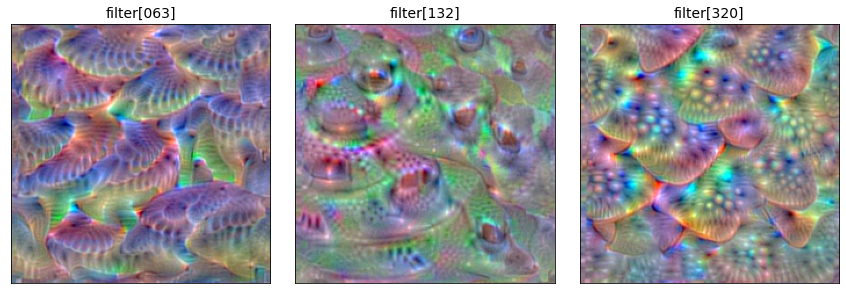

CPU times: user 12 s, sys: 253 ms, total: 12.2 s
Wall time: 13.3 s


In [9]:
%%time
from tf_keras_vis.activation_maximization.callbacks import GifGenerator2D
from tf_keras_vis.utils.input_modifiers import Jitter, Rotate

# Generate max activation
activations = activation_maximization(score,
                                      seed_input=seed_input,
                                      callbacks=[Logger(interval=100)])
# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (12, 4),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=14)
    ax[i].imshow(activations[i])
plt.tight_layout()
plt.savefig('images/visualize-filters')
plt.show()